# import libraries

In [9]:
import json
import tensorflow as tf

# load data

In [3]:
with open('sarcasm.json', 'r') as f:
  datastore = json.load(f)

In [4]:
sentences = []
labels = []

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [6]:
sentences[0]

"former versace store clerk sues over secret 'black code' for minority shoppers"

# split data

In [1]:
TRAINING_SIZE = 20000
VOCAB_SIZE = 10000
MAX_LENGTH = 32
EMBEDDING_DIM = 16

In [8]:
training_sentences = sentences[:TRAINING_SIZE]
testing_sentences = sentences[TRAINING_SIZE:]
training_labels = labels[:TRAINING_SIZE]
testing_labels = labels[TRAINING_SIZE:]

# encode, padding data, and make it to be tensor pipeline

In [11]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=MAX_LENGTH
)

# get the unique words with max length as the limit to training sentences
vectorize_layer.adapt(training_sentences)

# vectorize train and test data (create sequences from sentences)
# with no additional parameters, these already post-padded
train_sequences = vectorize_layer(training_sentences)
test_sequences = vectorize_layer(testing_sentences)

# re-combine data with the labels
train_dataset_vectorized = tf.data.Dataset.from_tensor_slices(
    (train_sequences, training_labels)
)
test_dataset_vectorized = tf.data.Dataset.from_tensor_slices(
    (test_sequences, testing_labels)
)

### 🔍 **Summary of `TextVectorization` with `max_tokens` and `output_sequence_length` in TensorFlow**

* `max_tokens=10000` limits the number of **unique words (vocabulary)** the model will keep from the entire dataset. Any word not in this vocabulary is treated as out-of-vocabulary (OOV).

* `output_sequence_length=32` defines the **fixed length** of the tokenized output for each input sentence:

  * If the sentence is **shorter**, it will be padded with zeros (`0`).
  * If the sentence is **longer**, it will be truncated.

* Each input sentence is converted into a **sequence of integers** where:

  * Each integer represents a word from the learned vocabulary.
  * Padding and OOV tokens are also represented numerically.

---

### 🧠 Example:

Input:
`"I love learning machine learning with TensorFlow"`

Vectorized Output (assuming MAX\_LENGTH = 8):
`[2, 3, 4, 5, 5, 6, 0, 0]`
(*Truncated or padded to ensure fixed length*)

---

### 🧩 Imagine this scenario:
You are training a text classification model on product reviews. Your corpus (dataset) contains 500,000 sentences with a total of 200,000+ unique words. But you set:
* max_tokens=10_000 → so only the 10,000 most frequent words are kept.
* output_sequence_length=32 → every sentence is converted to 32 tokens (words as integers).



In [12]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

In [13]:
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                      )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                    )

# modeling

In [14]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
            )

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           102 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,109 (625.43 KB)

 Trainable params: 160,109 (625.43 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
num_epochs = 30
history = model.fit(train_dataset_final,
                    epochs=num_epochs,
                    validation_data=test_dataset_final,
                    verbose=2
                  )

Epoch 1/30
625/625 - 6s - 9ms/step - accuracy: 0.6556 - loss: 0.6172 - val_accuracy: 0.7930 - val_loss: 0.4840
Epoch 2/30
625/625 - 2s - 4ms/step - accuracy: 0.8398 - loss: 0.3948 - val_accuracy: 0.8314 - val_loss: 0.3891
Epoch 3/30
625/625 - 2s - 4ms/step - accuracy: 0.8776 - loss: 0.3069 - val_accuracy: 0.8346 - val_loss: 0.3701
Epoch 4/30
625/625 - 2s - 4ms/step - accuracy: 0.9003 - loss: 0.2580 - val_accuracy: 0.8436 - val_loss: 0.3549
Epoch 5/30
625/625 - 3s - 5ms/step - accuracy: 0.9151 - loss: 0.2207 - val_accuracy: 0.8472 - val_loss: 0.3641
Epoch 6/30
625/625 - 5s - 8ms/step - accuracy: 0.9273 - loss: 0.1940 - val_accuracy: 0.8459 - val_loss: 0.3713
Epoch 7/30
625/625 - 4s - 7ms/step - accuracy: 0.9363 - loss: 0.1730 - val_accuracy: 0.8511 - val_loss: 0.3777
Epoch 8/30
625/625 - 3s - 5ms/step - accuracy: 0.9414 - loss: 0.1565 - val_accuracy: 0.8430 - val_loss: 0.4100
Epoch 9/30
625/625 - 4s - 7ms/step - accuracy: 0.9482 - loss: 0.1429 - val_accuracy: 0.8456 - val_loss: 0.4170
E

In [20]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

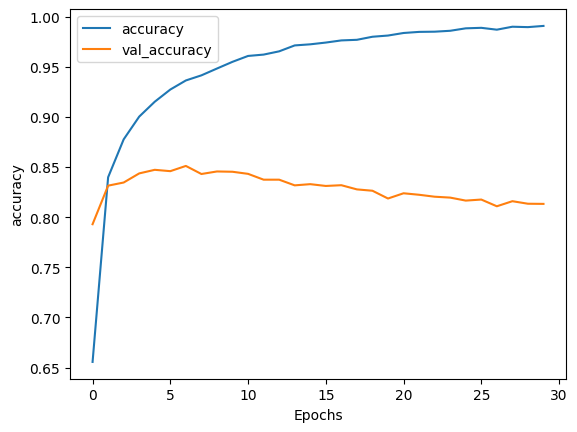

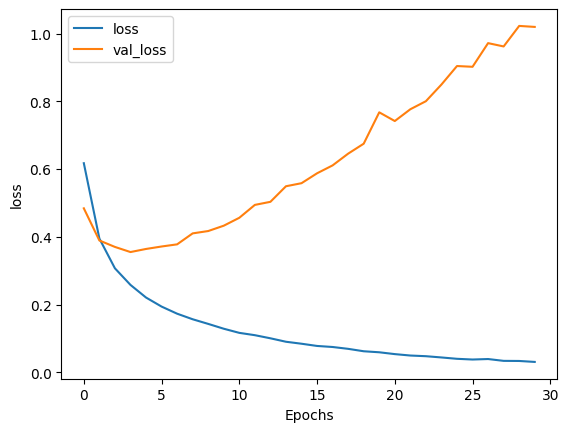

In [21]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

Loss:

* While the number of accurate predictions increased over time, what was interesting was that the confidence per prediction effectively decreased. tryna change/tweak the hyperparameters.

# tweak hyperparameter

In [28]:
TRAINING_SIZE = 20000
VOCAB_SIZE = 1000 # changed from 10k
MAX_LENGTH = 16 # changed from 32
EMBEDDING_DIM = 16

In [29]:
# re-adapt the TextVectorization layer with the new VOCAB_SIZE and MAX_LENGTH
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=MAX_LENGTH
)
vectorize_layer.adapt(training_sentences)

# re-create the training and testing datasets
train_sequences = vectorize_layer(training_sentences)
test_sequences = vectorize_layer(testing_sentences)

train_dataset_vectorized = tf.data.Dataset.from_tensor_slices(
    (train_sequences, training_labels)
)
test_dataset_vectorized = tf.data.Dataset.from_tensor_slices(
    (test_sequences, testing_labels)
)

# re-create train_dataset_final and test_dataset_final
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                      )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                    )

In [30]:
model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [31]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
            )

In [32]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 16, 16)         │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           102 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,109 (62.93 KB)

 Trainable params: 16,109 (62.93 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
num_epochs = 30
history = model2.fit(train_dataset_final,
                    epochs=num_epochs,
                    validation_data=test_dataset_final,
                    verbose=2
                  )

Epoch 1/30
625/625 - 3s - 4ms/step - accuracy: 0.7165 - loss: 0.5919 - val_accuracy: 0.7948 - val_loss: 0.4658
Epoch 2/30
625/625 - 2s - 2ms/step - accuracy: 0.8130 - loss: 0.4155 - val_accuracy: 0.8147 - val_loss: 0.4105
Epoch 3/30
625/625 - 3s - 4ms/step - accuracy: 0.8274 - loss: 0.3799 - val_accuracy: 0.8156 - val_loss: 0.4010
Epoch 4/30
625/625 - 3s - 4ms/step - accuracy: 0.8338 - loss: 0.3674 - val_accuracy: 0.8150 - val_loss: 0.4001
Epoch 5/30
625/625 - 3s - 5ms/step - accuracy: 0.8380 - loss: 0.3599 - val_accuracy: 0.8155 - val_loss: 0.4019
Epoch 6/30
625/625 - 1s - 2ms/step - accuracy: 0.8387 - loss: 0.3538 - val_accuracy: 0.8153 - val_loss: 0.3996
Epoch 7/30
625/625 - 3s - 4ms/step - accuracy: 0.8433 - loss: 0.3476 - val_accuracy: 0.8114 - val_loss: 0.4021
Epoch 8/30
625/625 - 3s - 4ms/step - accuracy: 0.8452 - loss: 0.3436 - val_accuracy: 0.8186 - val_loss: 0.3980
Epoch 9/30
625/625 - 2s - 2ms/step - accuracy: 0.8464 - loss: 0.3409 - val_accuracy: 0.8196 - val_loss: 0.3988
E

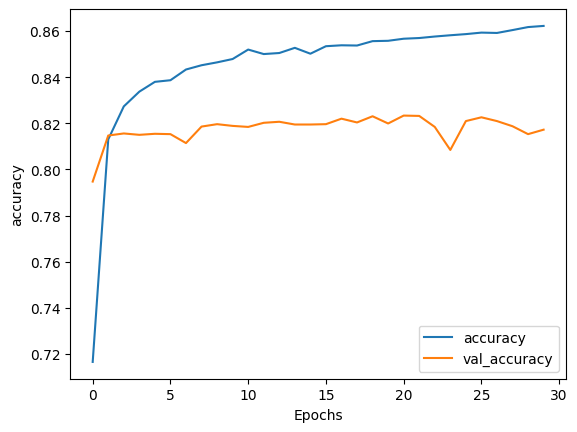

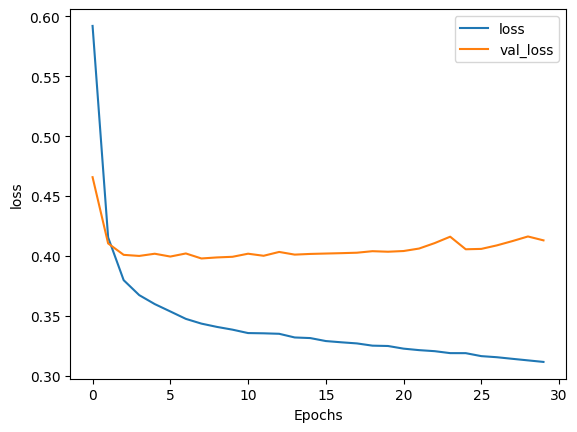

In [34]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

* loss is better than the previous one